This notebook loads the pickled dictionary with the presidents' raw and aggregated popularity, concatenates the raw popularity of each one, and saves all these data in a unique CSV file for sharing

In [72]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
all_presidents = pd.read_excel("../data/raw_popularity_presidents.xlsx", index_col=0, parse_dates=True)
all_presidents

president sondage  samplesize        method  approve_pr  \
1978-09-28       vge  Kantar        1040  face to face          60   
1978-10-17       vge    Ifop         949         phone          52   
1978-10-28       vge  Kantar         964  face to face          59   
1978-11-19       vge    Ifop        1069         phone          53   
1978-11-24       vge  Kantar         928  face to face          62   
...              ...     ...         ...           ...         ...   
2020-07-10    macron    Ifop        1018      internet          38   
2020-07-16    macron     BVA        1000      internet          39   
2020-07-16    macron    Ifop         974      internet          37   
2020-07-22    macron  Harris         960      internet          50   
2020-08-05    macron   Elabe        1002      internet          39   

            disapprove_pr  
1978-09-28             33  
1978-10-17             35  
1978-10-28             34  
1978-11-19             37  
1978-11-24             33  
...                   ...  
2020-07-10             62  
2020-07-16             61  
2020-07-16             63  
2020-07-22             50  
2020-08-05             56  

[1875 rows x 6 columns]

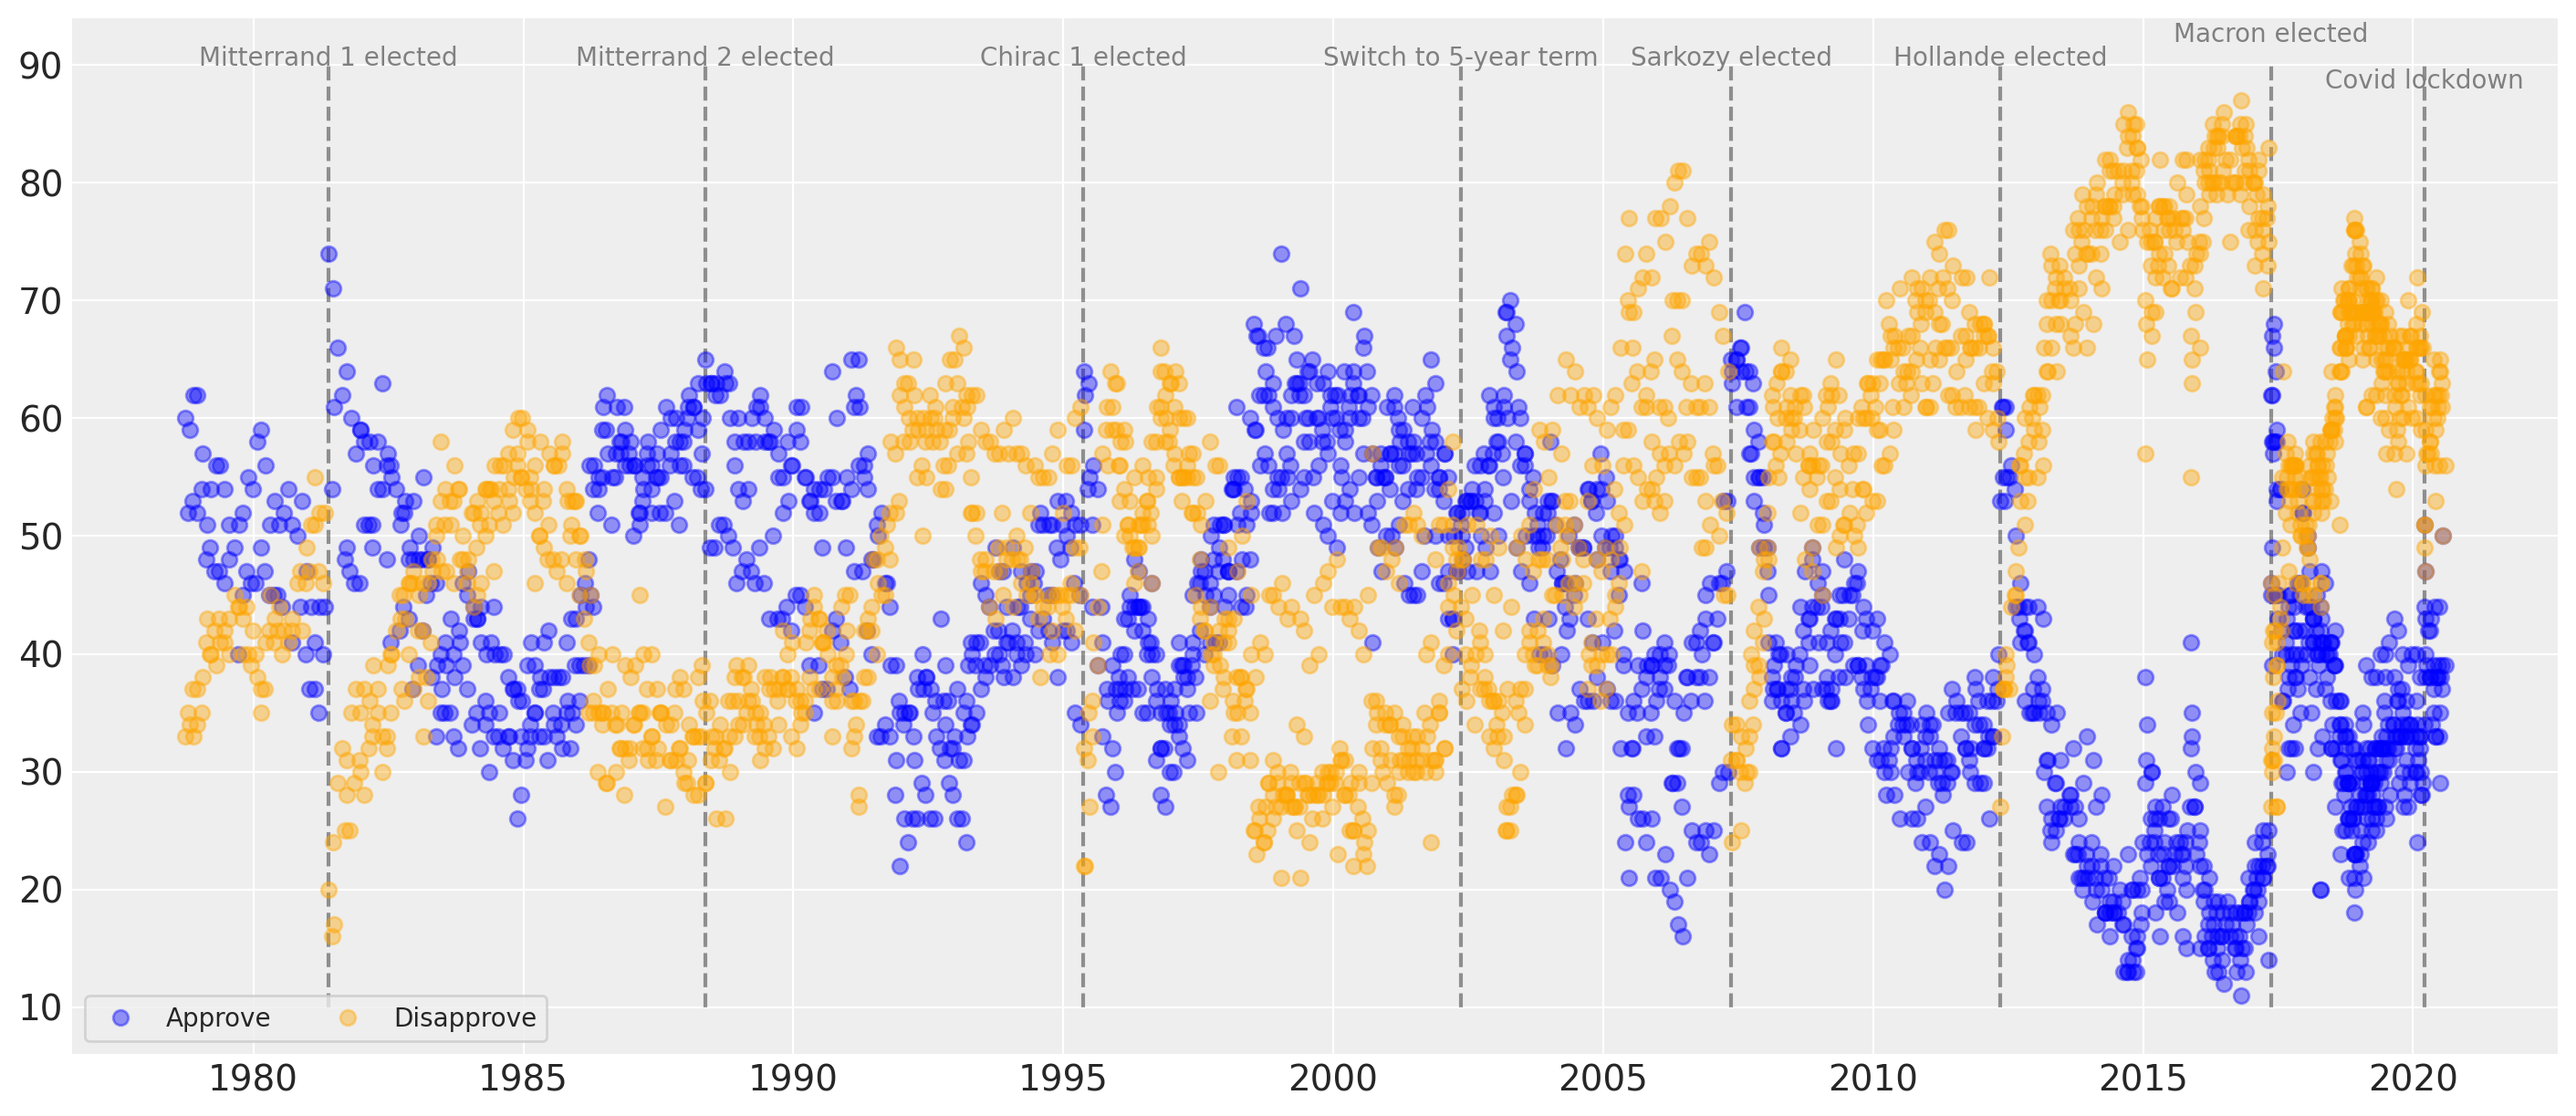

In [4]:
_, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(all_presidents.index, all_presidents.approve_pr, "ob", label="Approve", alpha=0.4)
ax.plot(all_presidents.index, all_presidents.disapprove_pr, "o", color="orange", label="Disapprove", alpha=0.4)

ax.vlines(pd.to_datetime("1981-05-25"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1981-05-25"), 90, "Mitterrand 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1988-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1988-05-16"), 90, "Mitterrand 2 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("1995-05-18"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("1995-05-18"), 90, "Chirac 1 elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2002-05-14"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2002-05-14"), 90, "Switch to 5-year term", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2007-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2007-05-16"), 90, "Sarkozy elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2012-05-11"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2012-05-11"), 90, "Hollande elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2017-05-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2017-05-17"), 92, "Macron elected", fontsize=10, color="grey", horizontalalignment="center")

ax.vlines(pd.to_datetime("2020-03-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(pd.to_datetime("2020-03-17"), 88, "Covid lockdown", fontsize=10, color="grey", horizontalalignment="center")

plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);

In [42]:
# restrict data to after the switch to 5-year term
#d = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]
# restrict data to Macron
d = all_presidents[all_presidents.president == "macron"]

# convert to proportions
d[["approve_pr", "disapprove_pr"]] = d[["approve_pr", "disapprove_pr"]].copy() / 100
d = d.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

# raw monthly average to get fixed time intervals
d = d[["samplesize", "p_approve", "p_disapprove"]].resample("M").mean()

# convert to nbr of successes
d["N_approve"] = d.samplesize * d["p_approve"]
d["N_disapprove"] = d.samplesize * d["p_disapprove"]
d[["N_approve", "N_disapprove"]] = d[["N_approve", "N_disapprove"]].round().astype(int)

# compute total trials
d["N_total"] = d.N_approve + d.N_disapprove
d

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


samplesize  p_approve  p_disapprove  N_approve  N_disapprove  \
2017-05-31  1122.300000   0.543000      0.353000        609           396   
2017-06-30  1721.727273   0.557273      0.359091        959           618   
2017-07-31  1195.600000   0.462000      0.448000        552           536   
2017-08-31  1028.666667   0.383333      0.561667        394           578   
2017-09-30  1134.000000   0.390000      0.538750        442           611   
2017-10-31  1156.625000   0.387500      0.555000        448           642   
2017-11-30  1124.625000   0.413750      0.518750        465           583   
2017-12-31  1296.250000   0.492500      0.467500        638           606   
2018-01-31  1123.666667   0.438889      0.498889        493           561   
2018-02-28  1122.625000   0.400000      0.535000        449           601   
2018-03-31  1172.000000   0.393333      0.558333        461           654   
2018-04-30  1110.727273   0.372727      0.520909        414           579   
2018-05-31  1009.600000   0.404000      0.556000        408           561   
2018-06-30  1115.875000   0.378750      0.582500        423           650   
2018-07-31  1138.857143   0.360000      0.601429        410           685   
2018-08-31  1017.625000   0.328750      0.636250        335           647   
2018-09-30  1107.400000   0.296000      0.678000        328           751   
2018-10-31  1106.272727   0.282727      0.684545        313           757   
2018-11-30  1122.500000   0.261000      0.711000        293           798   
2018-12-31  1133.500000   0.253750      0.730000        288           827   
2019-01-31  1098.545455   0.269091      0.710000        296           780   
2019-02-28  1084.300000   0.297000      0.675000        322           732   
2019-03-31  1080.230769   0.296923      0.683077        321           738   
2019-04-30  1102.666667   0.293333      0.677778        323           747   
2019-05-31  1160.555556   0.307778      0.673333        357           781   
2019-06-30  1092.666667   0.336667      0.643333        368           703   
2019-07-31   998.666667   0.320000      0.640000        320           639   
2019-08-31   974.800000   0.362000      0.634000        353           618   
2019-09-30  1111.625000   0.347500      0.611250        386           679   
2019-10-31  1112.750000   0.336250      0.631250        374           702   
2019-11-30  1104.875000   0.326250      0.637500        360           704   
2019-12-31  1131.333333   0.333333      0.650000        377           735   
2020-01-31  1129.000000   0.335714      0.644286        379           727   
2020-02-29  1096.777778   0.307778      0.652222        338           715   
2020-03-31  1096.888889   0.405556      0.553333        445           607   
2020-04-30  1174.400000   0.406000      0.582000        477           684   
2020-05-31  1126.428571   0.371429      0.594286        418           669   
2020-06-30  1124.714286   0.362857      0.612857        408           689   
2020-07-31   991.200000   0.398000      0.602000        394           597   
2020-08-31  1002.000000   0.390000      0.560000        391           561   

            N_total  
2017-05-31     1005  
2017-06-30     1577  
2017-07-31     1088  
2017-08-31      972  
2017-09-30     1053  
2017-10-31     1090  
2017-11-30     1048  
2017-12-31     1244  
2018-01-31     1054  
2018-02-28     1050  
2018-03-31     1115  
2018-04-30      993  
2018-05-31      969  
2018-06-30     1073  
2018-07-31     1095  
2018-08-31      982  
2018-09-30     1079  
2018-10-31     1070  
2018-11-30     1091  
2018-12-31     1115  
2019-01-31     1076  
2019-02-28     1054  
2019-03-31     1059  
2019-04-30     1070  
2019-05-31     1138  
2019-06-30     1071  
2019-07-31      959  
2019-08-31      971  
2019-09-30     1065  
2019-10-31     1076  
2019-11-30     1064  
2019-12-31     1112  
2020-01-31     1106  
2020-02-29     1053  
2020-03-31     1052  
2020-04-30     1161  
2020-05-31     1087  
2020-06-30     1097

In [55]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date. Useful for posterior predictions."""
    
    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")
    
    return np.asarray(t)

In [56]:
time = dates_to_idx(d.index)
time

array([ 0.        ,  0.98564652,  2.00414793,  3.02264934,  4.00829586,
        5.02679726,  6.01244379,  7.03094519,  8.0494466 ,  8.96938335,
        9.98788476, 10.97353128, 11.99203269, 12.97767921, 13.99618062,
       15.01468203, 16.00032855, 17.01882996, 18.00447648, 19.02297788,
       20.04147929, 20.96141605, 21.97991745, 22.96556397, 23.98406538,
       24.9697119 , 25.98821331, 27.00671472, 27.99236124, 29.01086265,
       29.99650917, 31.01501058, 32.03351198, 32.98630362, 34.00480503,
       34.99045155, 36.00895296, 36.99459948, 38.01310089, 39.03160229])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_structure_rotated_, eta, ls, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 227 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


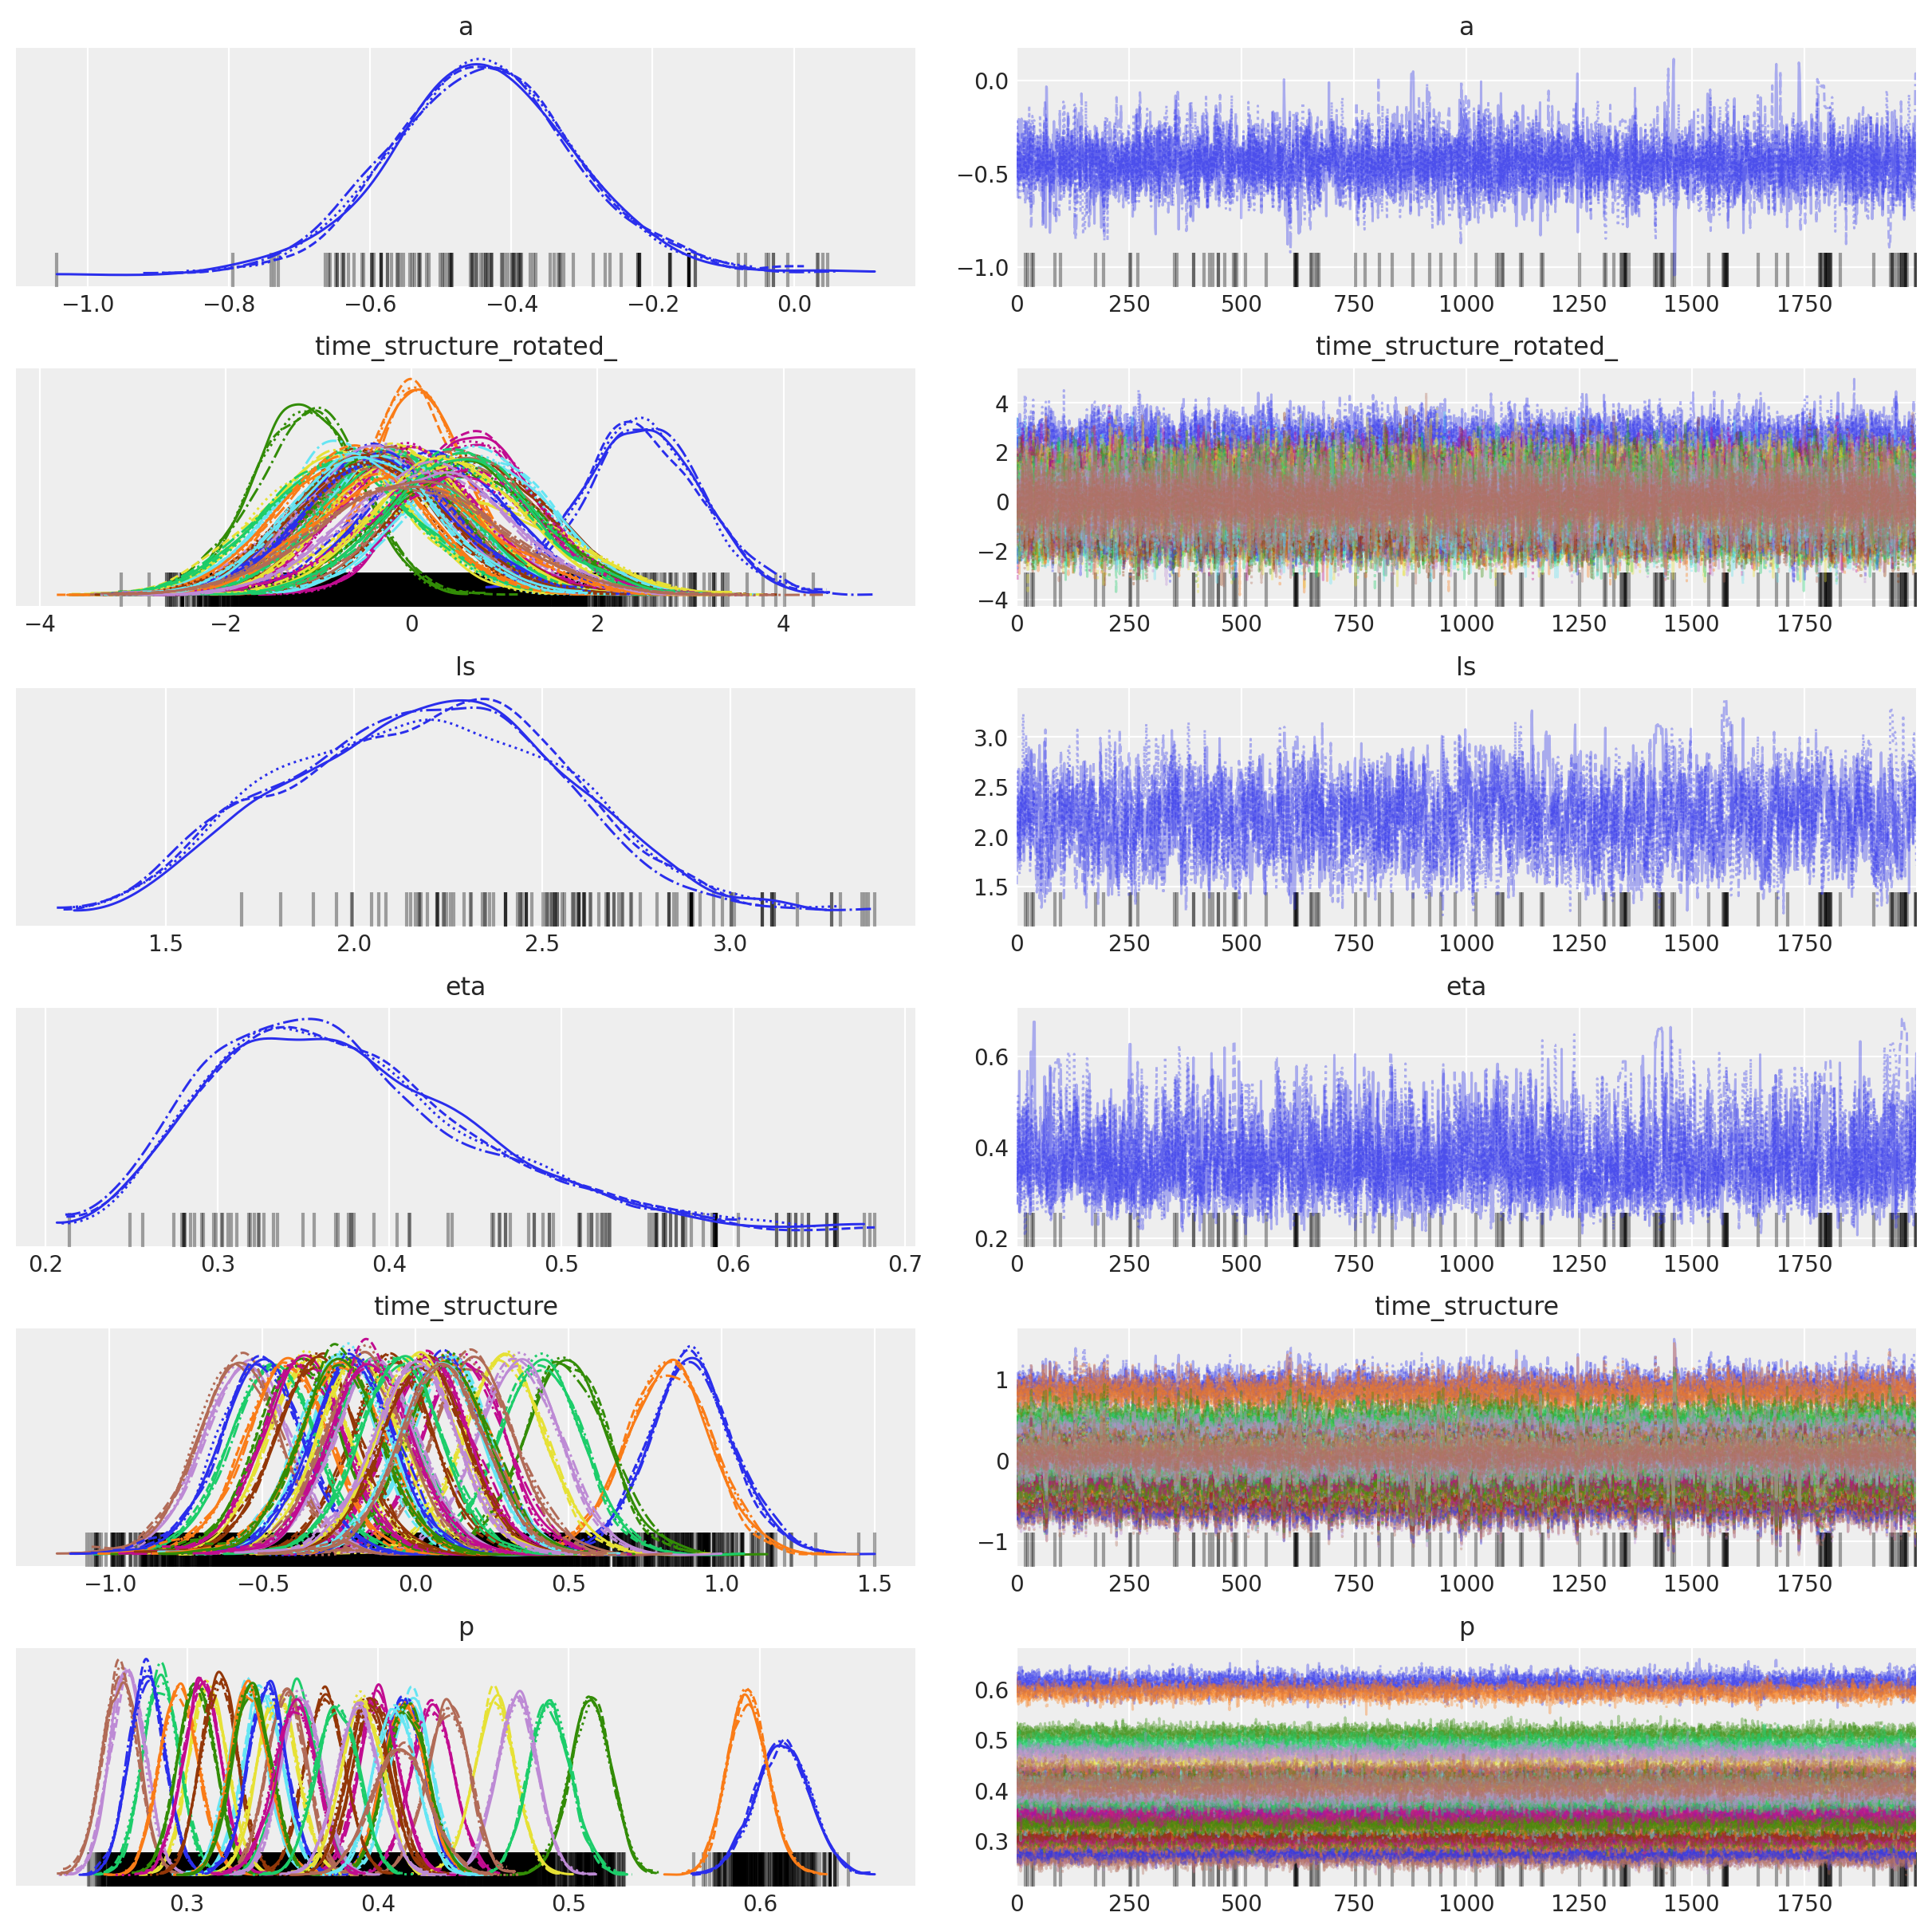

In [62]:
with pm.Model() as raw_latent_gp:
    
    # intercept on logit scale
    a = pm.Normal("a", -0.1, 1.)
    
    # informative lengthscale prior
    ls = pm.Gamma("ls", alpha=2, beta=1)
    # informative, positive normal prior on the period
    eta = pm.HalfNormal("eta", 5)
    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, ls)

    # mean is 0 by default
    gp = pm.gp.Latent(cov_func=cov)

    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # logit link and Binomial likelihood
    p = pm.Deterministic("p", pm.math.invlogit(a + f_time))
    y = pm.Binomial("y", p=p, n=d.N_total, observed=d.N_approve)

    trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    
az.plot_trace(trace, compact=True);

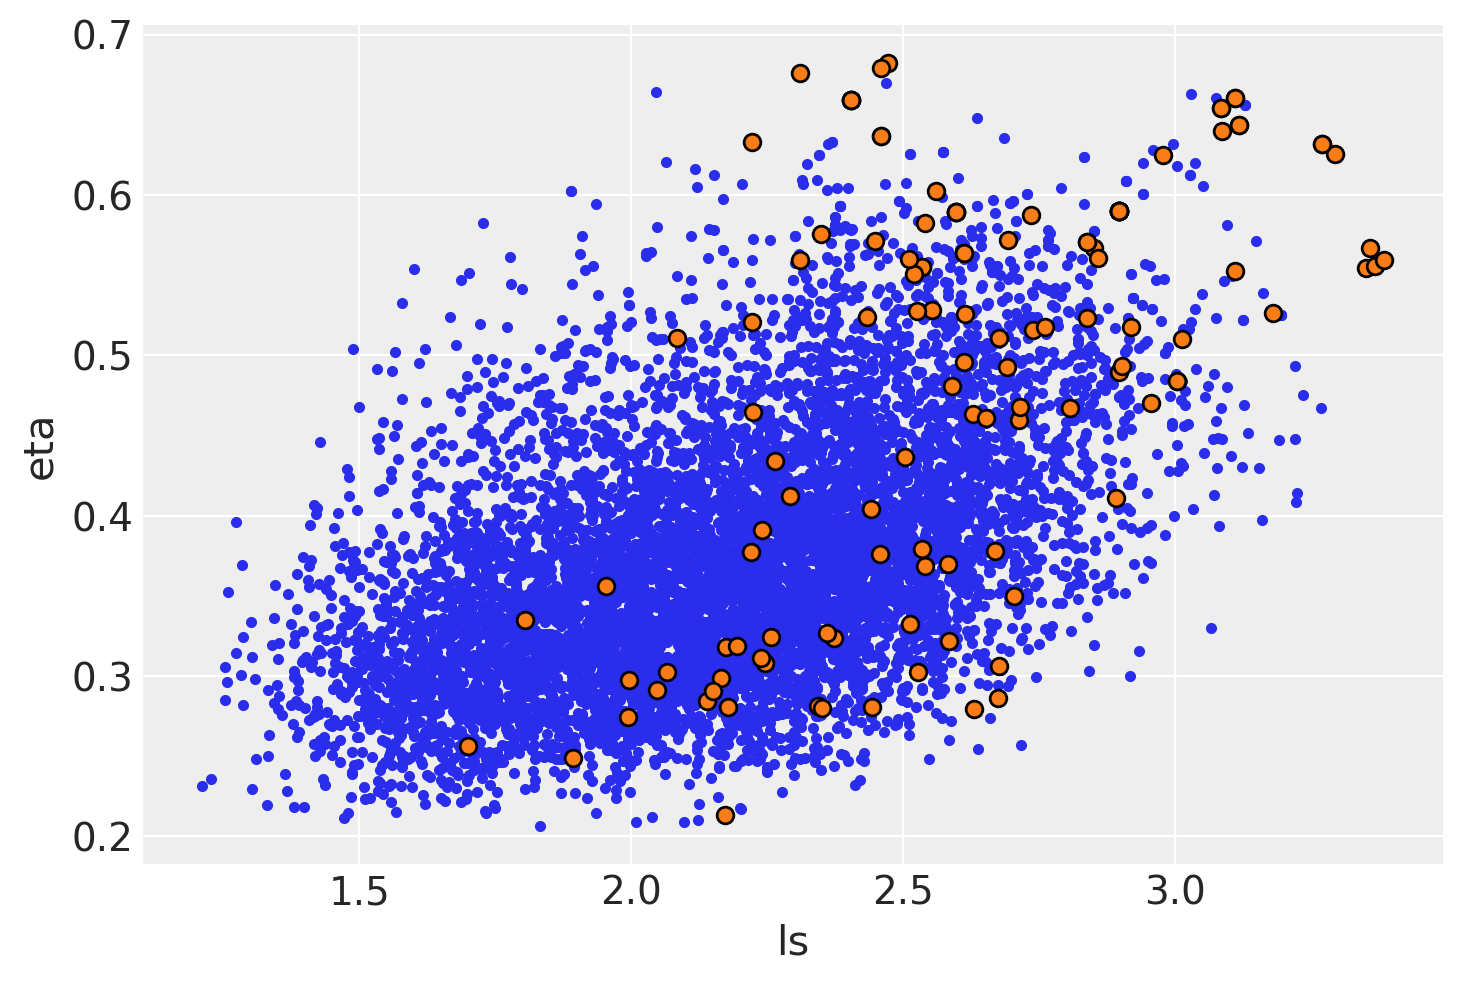

In [63]:
az.plot_pair(trace, var_names=["ls", "eta"], divergences=True);

In [76]:
tnew = np.linspace(-5, 60, 200)[:,None]
with raw_latent_gp:
    fnew = gp.conditional("fnew3", Xnew=tnew)
    ppc = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["a", "fnew3"])
    az.from_pymc3_predictions(
        ppc, idata_orig=trace, inplace=True
    )
    
pred = trace.predictions

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


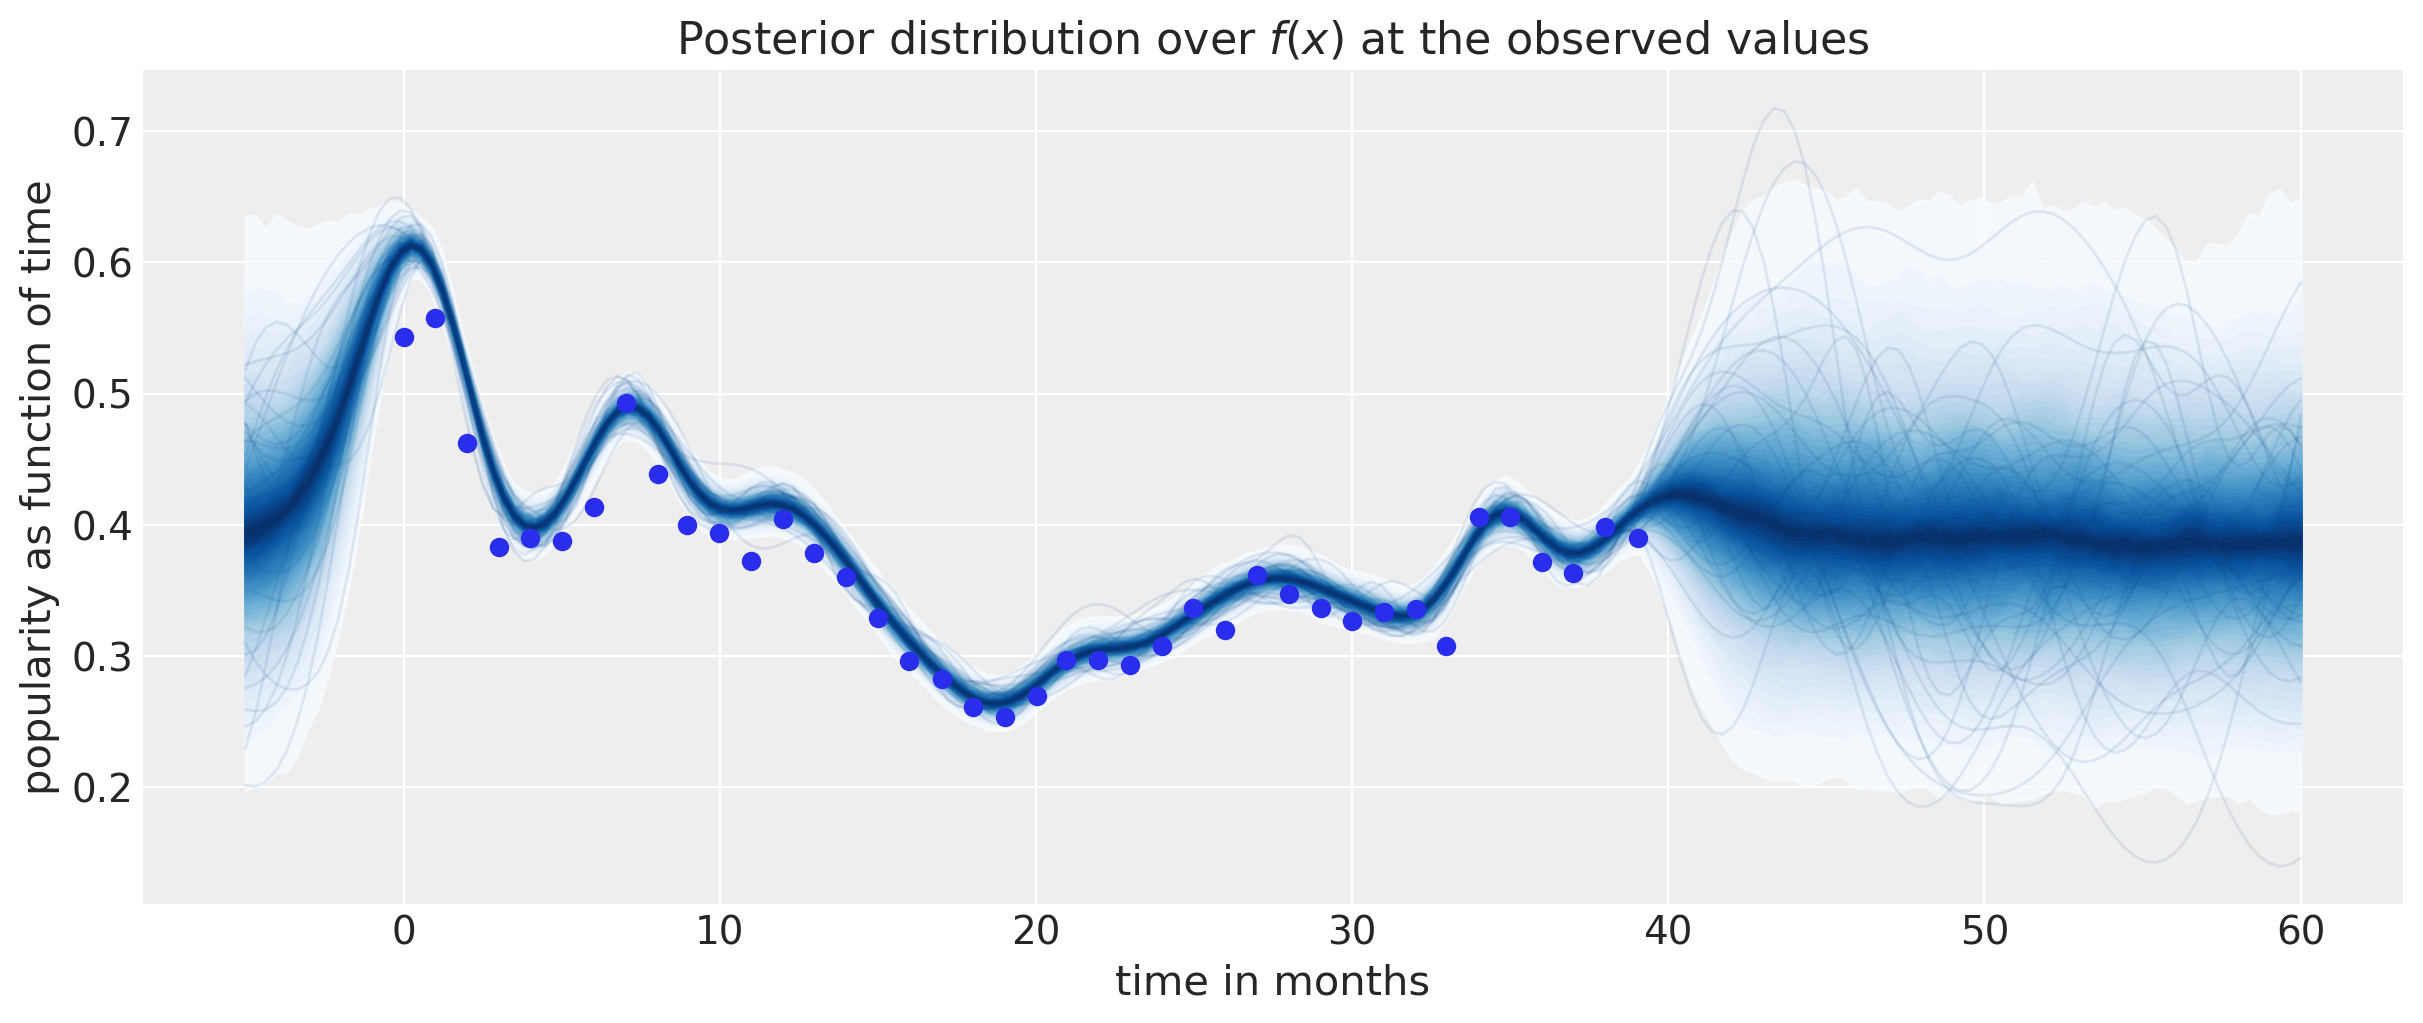

In [100]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
pp_prop = logistic(pred["a"] + pred["fnew3"]).stack(sample=("chain", "draw")).data.T
pm.gp.util.plot_gp_dist(ax, pp_prop, tnew, plot_samples=True, palette="Blues")

# plot the data
plt.plot(
    time,
    d.p_approve.values,
    "o",
)

# axis labels and title
plt.xlabel("time in months")
plt.ylabel("popularity as function of time")
plt.title("Posterior distribution over $f(x)$ at the observed values");

In [109]:
# https://betanalpha.github.io/assets/case_studies/probability_densities.html#25_the_gamma_family
# https://docs.pymc.io/notebooks/GP-MaunaLoa.html
# https://github.com/pymc-devs/pymc4/blob/master/notebooks/GP-Kernels.ipynb
# https://docs.pymc.io/notebooks/GP-MeansAndCovs.html

TypeError: 'ListedColormap' object is not iterable

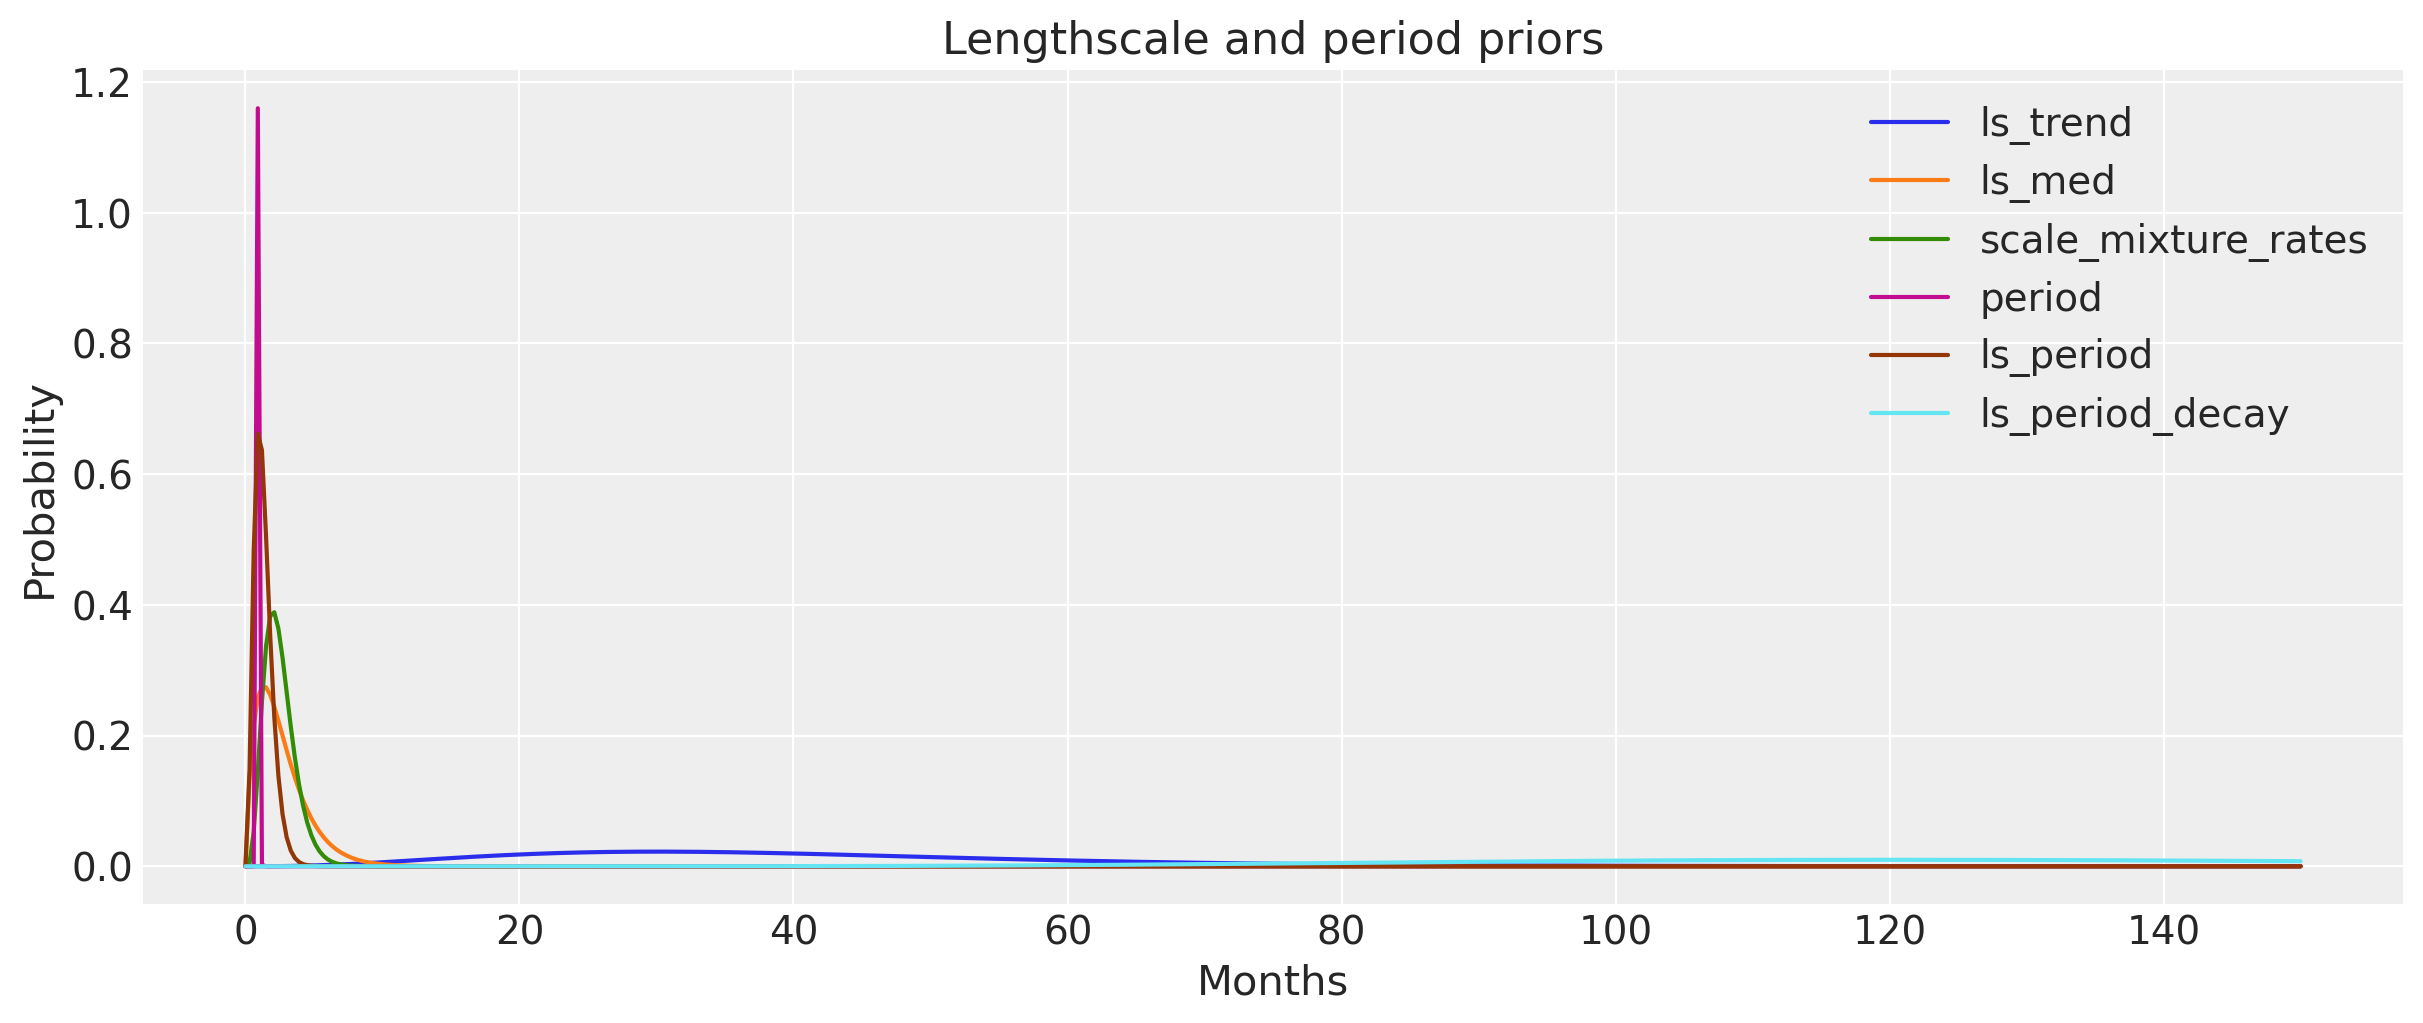

In [110]:
x = np.linspace(0, 150, 500)
priors = [
    ("ls_trend",  pm.Gamma.dist(alpha=4, beta=0.1)),
    ("ls_med", pm.Gamma.dist(alpha=2,  beta=0.75)),
    ("scale_mixture_rates", pm.Gamma.dist(alpha=5,  beta=2)),
    ("period", pm.Normal.dist(mu=1, sigma=0.05)),
    ("ls_period", pm.Gamma.dist(alpha=4,  beta=3)),
    ("ls_period_decay", pm.Gamma.dist(alpha=10, beta=0.075)),
]

fig = plt.figure(figsize=(12, 5))

for prior in priors:
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlabel("Months")
plt.ylabel("Probability")
plt.title("Lengthscale and period priors")
plt.legend();

In [ ]:
with pm.Model() as finer_latent_gp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.1, 1.)
    
    # long term trend
    amplitude_trend = pm.HalfNormal("amplitude_trend", 2)
    ls_trend = pm.Gamma("ls_trend", alpha=4, beta=0.1)
    
    cov_trend = amplitude_trend**2 * pm.gp.cov.Matern52(1, ls_trend)
    gp_trend = pm.gp.Latent(cov_func=cov_trend)
    
    # small/medium term irregularities
    amplitude_med = pm.HalfCauchy("amplitude_med", beta=0.5, testval=0.1)
    ls_med = pm.Gamma("ls_med", alpha=2, beta=0.75)
    scale_mixture_rates = pm.Gamma("scale_mixture_rates", alpha=5, beta=2) 
    
    cov_medium = amplitude_med**2 * pm.gp.cov.RatQuad(1, alpha=scale_mixture_rates, ls=ls_med)
    gp_medium = pm.gp.Latent(cov_func=cov_medium)
    
    # semi-periodic component
    amplitude_per = pm.HalfCauchy("amplitude_per", beta=2, testval=1.0)
    period  = pm.Normal("period", mu=1, sigma=0.05)
    ls_period = pm.Gamma("ls_period ", alpha=4, beta=3)
    ls_period_decay = pm.Gamma("ls_period_decay", alpha=10, beta=0.075)
    
    cov_seasonal = amplitude_per**2 * pm.gp.cov.Periodic(1, period, ls_period) * pm.gp.cov.Matern52(1, ls_period_decay)
    gp_seasonal = pm.gp.Latent(cov_func=cov_seasonal)

    # The Gaussian process is a sum of these three components
    gp = gp_trend + gp_medium + gp_seasonal

    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # logit link and Binomial likelihood
    p = pm.Deterministic("p", pm.math.invlogit(baseline + f_time))
    y = pm.Binomial("y", p=p, n=d.N_total, observed=d.N_approve)

    trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True)
    
az.plot_trace(trace, compact=True);